In [47]:
from dataset.data_preprocessing import *
from Preprocessing_Functions2 import *
from Training_Helper_Functions import *
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import pickle



In [48]:
load_and_preprocess_data("dataset/raw_data.csv") #? convert raw data to OHE and encoded version
data = pd.read_csv("dataset/processed_data_encoded.csv")

#? Split training and holdout/test set
trainVal, testing = train_test_split(data, test_size=0.1, random_state=42, stratify=data["DR"])

#? Split training and validation set
training, validation = train_test_split(trainVal, test_size=1/9, random_state=42, stratify=trainVal["DR"])


Processed (one-hot) data saved to processed_data_OHE.csv
Processed (label-encoded) data saved to processed_data_encoded.csv


In [245]:

def CV_generator(training:pd.DataFrame, validation:pd.DataFrame, OD_majority=None, OD_minority=None,synthesizer = "TVAE", epochs = 1000, n_synthetic_data=10000, scaler=StandardScaler()):
    cont_cols = ['Age', 'UAlb', 'Ucr', 'UACR', 'TC', 'TG', 'TCTG', 'LDLC', 'HDLC', 
             'Scr', 'BUN', 'FPG', 'HbA1c', 'Height', 'Weight', 'BMI', 'Duration']
    # Use the original encoded single column name here
    cat_cols = ['Gender', 'Community'] 
    y_col = 'DR'
    
    X = training.drop(columns=["BMI", "TCTG"])
    validation = validation.drop(columns=["BMI", "TCTG"])

    #* OUTLIER DETECTION
    X_train_processed = Outlier_Removal(X, 
                                    OD_majority=OD_majority,
                                    OD_minority=OD_minority,
    )
    # #* OVERSAMPLING & SYNTHETIC DATA GENERATION
    print("Before oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())
    #* SmoteNC
    X_train_processed = apply_smotenc_oversampling(X_train_processed)
    X_train_processed = Synthetic_Data_Generator2(X_train_processed, "", synthesizer=synthesizer, epochs=epochs, batch_size=256, n_synthetic_data=n_synthetic_data)
    print("After oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())

    
    #* Calculate BMI, TCTG & ENCODING
    X_train_processed, validation = get_bmi(X_train_processed, validation)
    X_train_processed, validation = get_TCTG(X_train_processed, validation)
    X_train_processed, validation = apply_one_hot_encoding(X_train_processed, validation)
    #* Scaler
    X_train_processed[cont_cols] = scaler.fit_transform(X_train_processed[cont_cols])
    validation[cont_cols] = scaler.transform(validation[cont_cols])
    # Append processed data (excluding the target column 'DR')

    # Save to CSV with fold number
    X_train_processed.to_csv(f"./DATA/training80.csv", index=False)
    validation.to_csv(f"./DATA/val10.csv", index=False)
    
    return

def final_generator(training:pd.DataFrame, test:pd.DataFrame,
OD_majority=None, OD_minority=None,synthesizer = "TVAE", epochs = 1000, n_synthetic_data=10000, scaler=StandardScaler()):
    cont_cols = ['Age', 'UAlb', 'Ucr', 'UACR', 'TC', 'TG', 'TCTG', 'LDLC', 'HDLC', 
             'Scr', 'BUN', 'FPG', 'HbA1c', 'Height', 'Weight', 'BMI', 'Duration']
    # Use the original encoded single column name here
    cat_cols = ['Gender', 'Community'] 
    y_col = 'DR'
    
    X = training.drop(columns=["BMI", "TCTG"])
    test = test.drop(columns=["BMI", "TCTG"])

    #* OUTLIER DETECTION
    X_train_processed = Outlier_Removal(X, 
                                    OD_majority=OD_majority,
                                    OD_minority=OD_minority,
    )
    # #* OVERSAMPLING & SYNTHETIC DATA GENERATION
    print("Before oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())
    #* SmoteNC
    X_train_processed = apply_smotenc_oversampling(X_train_processed)
    X_train_processed = Synthetic_Data_Generator2(X_train_processed, "", synthesizer=synthesizer, epochs=epochs, batch_size=256, n_synthetic_data=n_synthetic_data)
    print("After oversampling & synthetic data:", X_train_processed[["DR"]].value_counts())

    
    #* Calculate BMI, TCTG & ENCODING
    X_train_processed, test = get_bmi(X_train_processed, test)
    X_train_processed, test = get_TCTG(X_train_processed, test)
    X_train_processed, test = apply_one_hot_encoding(X_train_processed, test)
    #* Scaler
    X_train_processed[cont_cols] = scaler.fit_transform(X_train_processed[cont_cols])
    test[cont_cols] = scaler.transform(test[cont_cols])
    # Append processed data (excluding the target column 'DR')

    # Save to CSV with fold number
    X_train_processed.to_csv(f"./DATA/training90.csv", index=False)
    test.to_csv(f"./DATA/test10.csv", index=False)
    
    return

In [365]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# CV_generator(training, validation, OD_majority=None, OD_minority=None,synthesizer = "TVAE", epochs = 1000, n_synthetic_data=10000, scaler=StandardScaler())

CV_generator(training, validation,
            OD_majority = IQRDetector(factor=1),
            OD_minority = IQRDetector(factor=2),
            synthesizer = "TVAE",
            epochs = 1000,
            n_synthetic_data = 10000,
            scaler=StandardScaler())

# final_generator(training, testing, OD_majority=None, OD_minority=None,synthesizer = "TVAE", epochs = 1000, n_synthetic_data=10000, scaler=StandardScaler())

# final_generator(trainVal, testing,
#                 OD_majority = IQRDetector(factor=1.2),
#                 OD_minority = IQRDetector(factor=1.8),
#                 synthesizer = "TVAE",
#                 epochs = 1000,
#                 n_synthetic_data = 10000,
#                 scaler=StandardScaler())



Original class distribution: DR
0.0    4588
1.0     516
Name: count, dtype: int64
After OD, majority: 2305
After OD, minority: 395
Before oversampling & synthetic data: DR 
0.0    2305
1.0     395
Name: count, dtype: int64

Applying SMOTENC oversampling...
               Age       Gender   Community         UAlb           Ucr  \
count  4610.000000  4610.000000  4610.00000  4610.000000   4610.000000   
mean     63.458433     0.557050     3.87961    16.269190   3223.464213   
std       6.732329     0.496789     3.07017    21.292101   4880.049880   
min      36.000000     0.000000     0.00000     0.100000      0.000000   
25%      59.000000     0.000000     1.00000     4.500000      6.000000   
50%      63.789809     1.000000     4.00000     9.289380     10.000000   
75%      68.000000     1.000000     7.00000    18.891906   6194.533411   
max      87.000000     1.000000     9.00000   159.400000  19152.000000   

              UACR           TC           TG         LDLC         HDLC  \
co

d:\GitHub repos\ADL2\.venv\Lib\site-packages\sdv\single_table\base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: 9.735: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


Generating synthetic samples per class based on distribution...


Sampling conditions: 100%|██████████| 5000/5000 [00:00<00:00, 27232.35it/s]


Final synthetic class distribution:
DR
0.0    5000
1.0    5000
Name: count, dtype: int64
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 18/18 [00:01<00:00, 16.20it/s]|
Column Shapes Score: 91.54%

(2/2) Evaluating Column Pair Trends: |██████████| 153/153 [00:00<00:00, 390.78it/s]|
Column Pair Trends Score: 93.82%

Overall Score (Average): 92.68%

After oversampling & synthetic data: DR 
0.0    7305
1.0    7305
Name: count, dtype: int64


In [347]:

training80 = pd.read_csv("./DATA/training80.csv")
val10 = pd.read_csv("./DATA/val10.csv")
training90 = pd.read_csv("./DATA/training90.csv")
test10 = pd.read_csv("./DATA/test10.csv")

print((training80["DR"]==0).sum(), (training80["DR"]==1).sum())
print((val10["DR"]==0).sum(), (val10["DR"]==1).sum())

training80_x = training80.drop(columns=["DR"])
training80_x = training80_x.iloc[:,:-10]
training80_y = training80[["DR"]]
val10_x = val10.drop(columns=["DR"]) 
val10_x = val10_x.iloc[:,:-10]
val10_y = val10[["DR"]]
print(training80_x.head())


training90_x = training90.drop(columns=["DR"]).iloc[:,:-10]
training90_y = training90[["DR"]]
test10_x = test10.drop(columns=["DR"]).iloc[:,:-10]
test10_y = test10[["DR"]]

train80_loader, val10_loader = fold_to_dataloader_tensor(training80_x, val10_x, training80_y, val10_y, batch_size=700)
print(len(training80_x), len(val10_x), len(training80_y), len(val10_y))

training90_loader, test10_loader = fold_to_dataloader_tensor(training90_x, test10_x, training90_y, test10_y, batch_size=700)

6637 6637
574 64
        Age  Gender      UAlb       Ucr      UACR        TC        TG  \
0 -0.474814     1.0  0.440808 -0.652979 -0.366845  0.626286 -0.868502   
1  0.707448     1.0  0.244862  1.274331 -0.090733  0.149654 -0.494266   
2  0.032460     0.0 -0.337871 -0.652362 -0.309745  0.545564  0.873455   
3 -0.045833     1.0  0.426721 -0.653496  0.245258  0.056529 -0.581465   
4 -1.103588     1.0 -0.450198 -0.652194 -0.922081  2.124845  0.640731   

       LDLC      HDLC       Scr       BUN       FPG     HbA1c    Height  \
0  0.392805  0.864553 -0.303454  0.963485 -0.406852 -0.452434  0.230659   
1  0.488249  1.279793  0.495174  0.065663 -1.166740 -1.427600 -0.679796   
2  0.085510 -1.032520  0.268314  0.255550 -0.684078 -1.546165  1.057526   
3 -0.013908 -0.916185 -0.423560  0.238279 -0.836284 -1.204755 -1.100324   
4  1.477446  2.309271 -0.762816  0.250371 -1.337656 -1.320755 -0.754629   

     Weight  Duration       BMI      TCTG  
0  0.579787 -0.920109  0.556101  1.097437  
1  0.

In [366]:
training80 = pd.read_csv("./DATA/training80.csv")
val10 = pd.read_csv("./DATA/val10.csv")
training90 = pd.read_csv("./DATA/training90.csv")
test10 = pd.read_csv("./DATA/test10.csv")

print((training80["DR"]==0).sum(), (training80["DR"]==1).sum())
print((val10["DR"]==0).sum(), (val10["DR"]==1).sum())

training80_x = training80.drop(columns=["DR"])
training80_y = training80[["DR"]]
val10_x = val10.drop(columns=["DR"]) 
val10_y = val10[["DR"]]
print(training80_x.head())


training90_x = training90.drop(columns=["DR"])
training90_y = training90[["DR"]]
test10_x = test10.drop(columns=["DR"])
test10_y = test10[["DR"]]

train80_loader, val10_loader = fold_to_dataloader_tensor(training80_x, val10_x, training80_y, val10_y, batch_size=700)
print(len(training80_x), len(val10_x), len(training80_y), len(val10_y))

training90_loader, test10_loader = fold_to_dataloader_tensor(training90_x, test10_x, training90_y, test10_y, batch_size=700)

7305 7305
574 64
        Age  Gender      UAlb       Ucr      UACR        TC        TG  \
0 -0.101073     1.0 -0.458312 -0.703236 -0.380770  1.146455 -0.979640   
1  1.238896     1.0  1.262823  1.143146  1.333538 -1.060509 -0.447098   
2 -1.455757     0.0  0.113169  1.606091 -0.408541 -0.554893 -0.852471   
3 -1.088093     0.0 -0.507225  1.756316 -0.534730  1.280594  3.455992   
4  1.276811     1.0 -0.173988 -0.700969 -0.276620  0.070977 -0.713904   

       LDLC      HDLC       Scr  ...  Community_Community_baihe  \
0  0.652017  1.181163 -1.198576  ...                          0   
1 -0.792978 -1.241285  0.266168  ...                          0   
2 -0.983636 -1.321180  0.233296  ...                          0   
3  0.943403 -1.681783  1.759392  ...                          0   
4 -0.870651  0.401115 -0.551524  ...                          0   

   Community_Community_chonggu  Community_Community_huaxin  \
0                            0                           0   
1                

In [368]:
import pickle
class Ivan_NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 2180)
        self.drop = nn.Dropout(0.7)
        self.input_fc2 = nn.Linear(2180,1248)  # ← Fixed this
        self.input_bn = nn.BatchNorm1d(1248)
        
        

        self.block1 = nn.Sequential(
            nn.Linear(1248, 888),
            nn.BatchNorm1d(888),
            nn.LeakyReLU(),
            nn.Dropout(0.4)
        )

        self.block2 = nn.Sequential(
            nn.Linear(888, 1122),
            nn.BatchNorm1d(1122),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block3 = nn.Sequential(
            nn.Linear(1122, 624),
            nn.BatchNorm1d(624),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block4 = nn.Sequential(
            nn.Linear(624, 1080),
            nn.BatchNorm1d(1080),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block5 = nn.Sequential(
            nn.Linear(1080, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.7)
        )

        self.block6 = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),  # ← Fixed this
            nn.LeakyReLU(),
            nn.Dropout(0.6)
        )

        self.block7 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.4)
        )

        self.block8 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),  
            nn.Dropout(0.3)
        )

        self.output = nn.Linear(32, 1)

        # Skip connection projectors
        self.skip1_proj = nn.Sequential(nn.Linear(1248, 1122))
        self.skip2_proj = nn.Sequential(nn.Linear(1122, 128))
        self.skip3_proj = nn.Sequential(nn.Linear(128, 32))

    def forward(self, x):
        x = self.input_fc(x)
        x = self.drop(x)
        x = self.input_fc2(x)
        x = self.input_bn(x)
        x = torch.nn.functional.leaky_relu(x)
        

        x1 = self.block1(x)
        x2 = self.block2(x1)

        skip1 = self.skip1_proj(x)
        x2 = x2 + skip1

        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x5 = self.block5(x4)

        x6 = self.block6(x5)

        skip2 = self.skip2_proj(x2)
        x6 = x6 + skip2

        x7 = self.block7(x6)
        x8 = self.block8(x7)

        skip3 = self.skip3_proj(x6)
        x8 = x8 + skip3

        out = self.output(x8)
        return out
    
import torch
import torch.nn as nn

import torch.nn as nn

# class Ivan_NN2(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.Dropout(0.8),

#             nn.Linear(512, 128),
#             # nn.BatchNorm1d(128),
#             nn.LeakyReLU(),
#             nn.Dropout(0.9),

#             nn.Linear(128, 32),
#             nn.BatchNorm1d(32),
#             nn.LeakyReLU(),
#             nn.Dropout(0.8),

#             nn.Linear(32, 1)
#         )

#     def forward(self, x):
#         return self.model(x)

# class Ivan_NN2(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 52),
#             nn.Dropout(0.5),
#             nn.Softshrink(),
#             nn.Linear(52, 64),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         return self.net(x)

class Ivan_NN2(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 56),
            nn.BatchNorm1d(56),
            nn.Dropout(0.2),
            
            nn.LeakyReLU(),
            nn.Linear(56, 13),
            nn.BatchNorm1d(13),
            nn.Dropout(0.1),
            
            nn.LeakyReLU(),
            nn.Linear(13, 1),
        )

    def forward(self, x):
        return self.net(x)
 
def train_model(model:Ivan_NN, nFeatures:int, train80_loader, val10_loader, epochs=10, learningRate = 0.0001, threshold:float = 0.5, patience = 30, device=None):
    # Use GPU if available
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    theMODEL = model(nFeatures)
    theMODEL.to(device)
    print(theMODEL)

    # posWeight = torch.tensor(10, dtype=torch.float32).to("cpu")
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10, dtype=torch.float32)) #pos_weight=posWeight)
    optimizer = optim.Adam(theMODEL.parameters() ,lr=learningRate, weight_decay=1e-1)
    # optimizer = torch.optim.SGD(theMODEL.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=1e-5,
            max_lr=1e-4,
            cycle_momentum=False)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies= []
    val_precisions = []
    val_recalls = []
    val_f1s = []
    best_val_loss = float("inf")
    best_val_f1 = .0


    for epoch in range(epochs):
        theMODEL.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train80_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            # Forward pass
            outputs = theMODEL(inputs).squeeze()
            loss = criterion(outputs, targets)
            # Backward and optimize
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.5)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()# * inputs.size(0)

            # preds = torch.round(torch.sigmoid(outputs))
            preds = (torch.sigmoid(outputs) >= threshold).float()

            correct += (preds == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        

        # Validation
        theMODEL.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val10_loader:
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = theMODEL(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item() # * inputs.size(0)

                if pd.isna(loss.item()):
                    print( "Val Loss:" ,loss)
                    in_rows = torch.isnan(inputs).any(axis=1)
                    out_rows = torch.isnan(outputs).any(axis=-1)
                    targets_rows = torch.isnan(targets).any(axis=-1)
                    print(inputs[in_rows], outputs[out_rows], targets[targets_rows],sep="\n")
                    return
                
                # preds = torch.round(torch.sigmoid(outputs))
                preds = (torch.sigmoid(outputs) >= threshold).float()
                targets = targets.cpu()
                preds = preds.cpu() 
                val_correct += (preds == targets).sum().item()
                val_total += targets.size(0)

                f1Score = f1_score(targets, preds)
                precision = precision_score(targets,preds,zero_division=.0)
                recall = recall_score(targets, preds)
                accuracy = accuracy_score(targets,preds)


        if val_total == 0:
            print("Empty validation set!")
            return

        val_loss /= val_total
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_precisions.append(precision)
        val_recalls.append(recall)
        val_f1s.append(f1Score)

        print(f"Epoch [{epoch+1}/{epochs}]".ljust(16),
              f"Train Loss: {train_loss:.6f} Acc: {train_acc:.6f} | "
            #   f"Val Loss: {val_loss:.6f} Acc: {val_acc:.6f}"
              f"Val Loss: {val_loss:.6f} Acc: {accuracy:.2f}% Precision: {precision:.2f} Recall: {recall:.2f} F1: {f1Score:.2f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_loss_model = {
                "epoch": epoch+1,
                "stateDict": theMODEL.state_dict(),
            }
            print("Best loss model saved!")
        if f1Score > best_val_f1:
            best_val_f1 = f1Score
            best_f1_model = {
                "epoch": epoch+1,
                "stateDict": theMODEL.state_dict(),
            }
            print("Best f1 model saved!")
            
        elif val_loss > best_val_loss and epoch > best_loss_model["epoch"] + patience:
            print(f"Early stopping... Current Val Loss:{val_loss}  vs  Best Val Loss: {best_val_loss}")
            break

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='^')
    plt.plot(val_losses, label='Val Loss', marker='x')
    plt.title("Training vs. Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Acc', marker='^')
    plt.plot(val_accuracies, label='Val Acc', marker='x')
    plt.title("Training vs. Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(val_precisions, label='Val Precision', marker='^')
    plt.plot(val_recalls, label='Val Recall', marker='x')
    plt.plot(val_f1s, label='Val F1', marker='|')
    plt.title("Precision, Recall, F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    trainingData = {
        "learningRate": learningRate,
        "epochs": (epoch, epochs),
        "treshold": threshold,
        "initial training loss": train_losses,
        "initial training acc": train_accuracies,
        "initial validation loss": val_losses,
        "initial validation acc": val_accuracies,
        "initial validation precision": val_precisions,
        "initial validation recall": val_recalls,
        "initial validation F1":val_f1s, 
        # "best initial loss model": best_loss_model,
        # "best initial f1 model": best_f1_model,
    }
    
    with open("loss_model.pkl", "wb") as f:
        pickle.dump(best_loss_model, f)
        print("Fiile saved")
        
    with open("f1_model.pkl", "wb") as f:
        pickle.dump(best_f1_model, f)
        print("Fiile saved")
        
    return trainingData

def train_loss_model(model:Ivan_NN, nFeatures:int, bestModelData:dict, training90_loader, test10_loader, epochs=20, learningRate = 0.00001, threshold:float = 0.5, device=None):
    # Use GPU if available
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading best loss model State from epoch {bestModelData['epoch']}")
    finalModel = model(nFeatures)
    finalModel.load_state_dict(bestModelData["stateDict"])
    
    posWeight = torch.tensor(10, dtype=torch.float32).to("cpu")
    criterion = nn.BCEWithLogitsLoss(pos_weight=posWeight)
    optimizer = optim.Adam(finalModel.parameters() ,lr=learningRate, weight_decay=1e-1)
    scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=1e-5,
            max_lr=1e-4,
            cycle_momentum=False)

    train_losses = []
    train_accuracies = []

    for epoch in range(bestModelData["epoch"]):
        finalModel.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in training90_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            # Forward pass
            outputs = finalModel(inputs).squeeze()
            loss = criterion(outputs, targets)
            # Backward and optimize
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.5)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()# * inputs.size(0)

            # preds = torch.round(torch.sigmoid(outputs))
            preds = (torch.sigmoid(outputs) >= threshold).float()
            targets = targets.cpu()
            preds = preds.cpu() 

            correct += (preds == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}]".ljust(16),
              f"Train Loss: {train_loss:.6f} Acc: {train_acc:.6f}")
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)


    finalModel.eval()   

    with torch.no_grad():
        for inputs, targets in test10_loader:
            inputs, targets = inputs.to(device), targets.squeeze().to(device)
            outputs = finalModel(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss = loss.item() # * inputs.size(0)

            # preds = torch.round(torch.sigmoid(outputs))
            preds = (torch.sigmoid(outputs) >= threshold).float()
            targets = targets.cpu()
            preds = preds.cpu() 
            test_f1Score = f1_score(targets, preds)
            test_precision = precision_score(targets,preds)
            test_recall = recall_score(targets, preds)
            test_accuracy = accuracy_score(targets,preds)

            qwerty = [
                f"Loss: {test_loss:.6f}", 
                f"Accuracy: {test_accuracy:.2f}%", 
                f"Precision: {test_precision:.2f}", 
                f"Recall: {test_recall:.2f}", 
                f"F1 Score: {test_f1Score:.2f}",
            ]
            wwidth = 30
            print("Test Results".center(16).center(wwidth,"="))
            for line in qwerty:
                print(line.ljust(16).center(wwidth-2).center(wwidth,"|"))
            # print("Test", f"Loss: {test_loss:.6f}", f"Accuracy: {test_accuracy:.2f}%", f"Precision: {test_precision:.2f}", f"Recall: {test_recall:.2f}", f"F1 Score: {test_f1Score:.2f}%", sep="\n ")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='^')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Acc', marker='^')
    plt.title("Training Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    loss_Model = {
        "final training loss": train_losses,
        "final training acc": train_accuracies,
        "Test loss": test_loss,
        "Test acc": test_accuracy,
        "Test precision": test_precision,
        "Test recall": test_recall,
        "Test F1": test_f1Score,
        "final model": finalModel.state_dict(),
    }
    
    with open("Loss_Model.pkl", "wb") as f:
        pickle.dump(finalModel.state_dict(), f)
        print("Loss Model State Dict saved")

    
        
    return loss_Model

def train_f1_model(model:Ivan_NN, nFeatures:int, bestModelData:dict, trainVal_loader, test_loader, learningRate = 0.00001, threshold:float = 0.5, device=None):
    # Use GPU if available
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Loading best f1 model State from epoch {bestModelData['epoch']}")
    f1Model = model(nFeatures).to(device)
    f1Model.load_state_dict(bestModelData["stateDict"])
    posWeight = torch.tensor(10, dtype=torch.float32).to("cpu")
    criterion = nn.BCEWithLogitsLoss(pos_weight=posWeight)
    optimizer = optim.Adam(f1Model.parameters() ,lr=learningRate, weight_decay=1e-1)
    scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=1e-5,
            max_lr=1e-4,
            cycle_momentum=False)

    train_losses = []
    train_accuracies = []

    for epoch in range(bestModelData['epoch']):
        f1Model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in trainVal_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.squeeze().to(device)

            # Forward pass
            outputs = f1Model(inputs).squeeze()
            loss = criterion(outputs, targets)
            # Backward and optimize
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=.5)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()# * inputs.size(0)

            preds = torch.round(torch.sigmoid(outputs))
            preds = (torch.sigmoid(outputs) >= threshold)

            correct += (preds == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch [{epoch+1}/{bestModelData['epoch']}]".ljust(16),
              f"Train Loss: {train_loss:.6f} Acc: {train_acc:.6f} | ")
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)


    f1Model.eval()   

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.squeeze().to(device)
            outputs = f1Model(inputs).squeeze()
            loss = criterion(outputs, targets)
            test_loss = loss.item() # * inputs.size(0)

            # preds = torch.round(torch.sigmoid(outputs))
            
            preds = (torch.sigmoid(outputs) >= threshold).float()
            targets = targets.cpu()
            preds = preds.cpu() 

            test_f1Score = f1_score(targets, preds)
            test_precision = precision_score(targets,preds)
            test_recall = recall_score(targets, preds)
            test_accuracy = accuracy_score(targets,preds)
            test_auc = roc_auc_score(targets, preds)

            qwerty = [
                f"Loss: {test_loss:.6f}", 
                f"Accuracy: {test_accuracy:.2f}%", 
                f"Precision: {test_precision:.2f}", 
                f"Recall: {test_recall:.2f}", 
                f"F1 Score: {test_f1Score:.2f}",
                f"AUC Score: {test_auc:.2f}",
            ]
            wwidth = 30
            print("Test Results".center(16).center(wwidth,"="))
            for line in qwerty:
                print(line.ljust(16).center(wwidth-2).center(wwidth,"|"))
            # print("Test", f"Loss: {test_loss:.6f}", f"Accuracy: {test_accuracy:.2f}%", f"Precision: {test_precision:.2f}", f"Recall: {test_recall:.2f}", f"F1 Score: {test_f1Score:.2f}%", sep="\n ")

    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='^')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, label='Train Acc', marker='^')
    plt.title("Training Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    f1_Model = {
        "final training loss": train_losses,
        "final training acc": train_accuracies,
        "Test loss": test_loss,
        "Test acc": test_accuracy,
        "Test precision": test_precision,
        "Test recall": test_recall,
        "Test F1": test_f1Score,
        "final model": f1Model.state_dict(),
    }
    with open("f1_model.pkl", "wb") as f:
        pickle.dump(f1Model.state_dict(), f)
        print("F1 Model State Dict saved")
    
    return f1_Model

In [369]:
#?  hyperparameter declarations
nInputs = len(training80_x.columns)
epoch = 1000
learningRate = 0.0002
threshold = 0.5
patience = 300

Ivan_NN2(
  (net): Sequential(
    (0): Linear(in_features=28, out_features=56, bias=True)
    (1): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=56, out_features=13, bias=True)
    (5): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=13, out_features=1, bias=True)
  )
)
Epoch [1/1000]   Train Loss: 0.006517 Acc: 0.497286 | Val Loss: 0.002046 Acc: 0.70% Precision: 0.15 Recall: 0.41 F1: 0.21
Best loss model saved!
Best f1 model saved!
Epoch [2/1000]   Train Loss: 0.006499 Acc: 0.498714 | Val Loss: 0.002034 Acc: 0.69% Precision: 0.15 Recall: 0.44 F1: 0.22
Best loss model saved!
Best f1 model saved!
Epoch [3/1000]   Train Loss: 0.006488 Acc: 0.502000 | Val Loss: 0.002027 Acc: 0.68% Precision: 0.14 Recall: 0.44 F1:

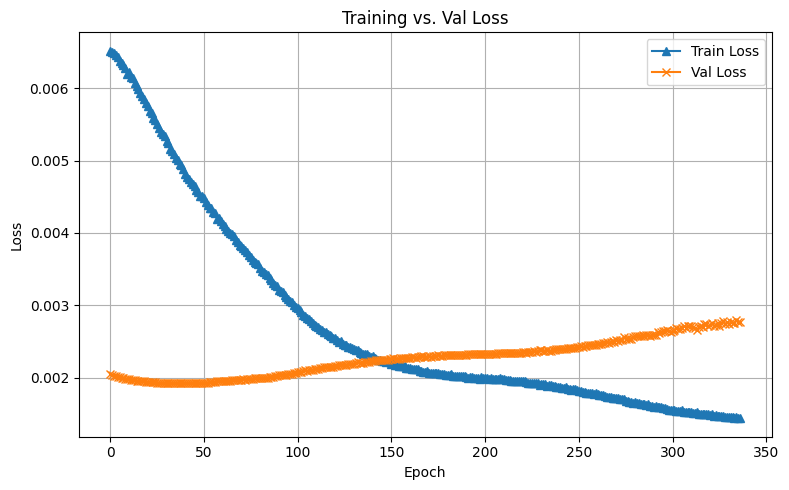

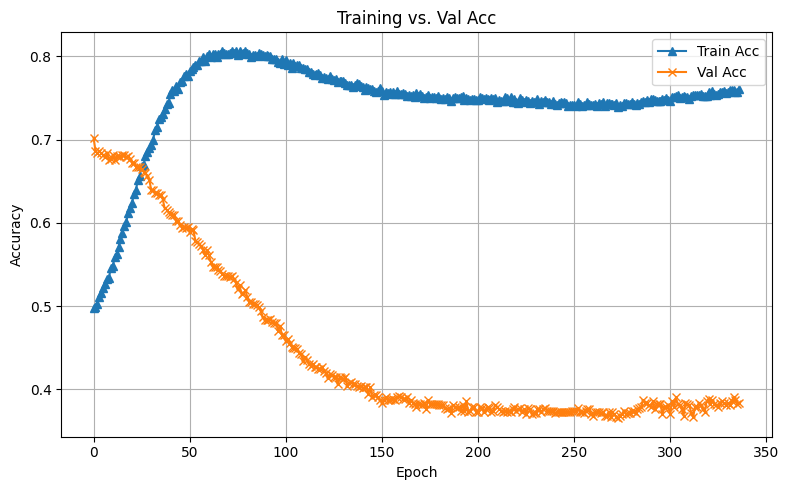

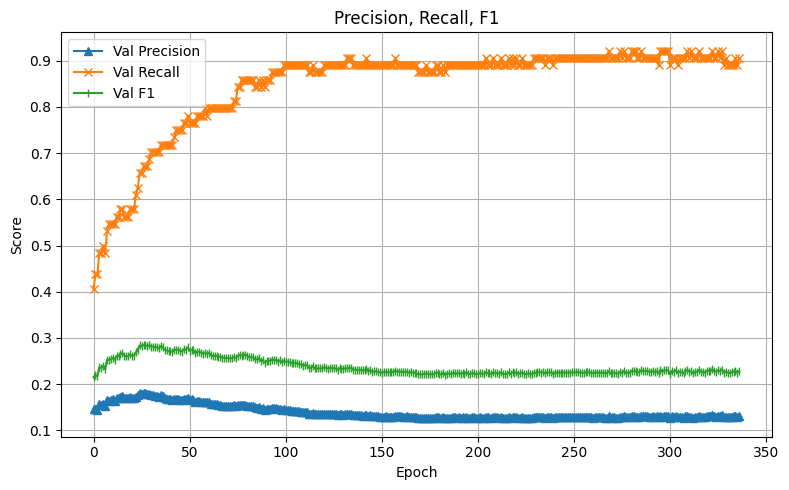

Fiile saved
Fiile saved
Training Data saved


In [370]:
 
#? main model training and validation loop
trainingData = train_model(Ivan_NN2, nInputs, train80_loader, val10_loader, epochs=epoch, learningRate=learningRate, threshold=threshold, patience=patience)

# with open("trainingData.pkl", "w") as f:
#     pickle.dump(trainingData, f)
#     print("Training Data saved")    

with open("output.txt", "w") as f:
    for key, value in trainingData.items():
        f.write(f"{key}: {value}\n")
    print("Training Data saved")  


Loading best f1 model State from epoch 157
Epoch [1/157]    Train Loss: 0.002863 Acc: 0.694714 | 
Epoch [2/157]    Train Loss: 0.002746 Acc: 0.700857 | 
Epoch [3/157]    Train Loss: 0.002847 Acc: 0.707429 | 
Epoch [4/157]    Train Loss: 0.002830 Acc: 0.699000 | 
Epoch [5/157]    Train Loss: 0.002867 Acc: 0.696429 | 
Epoch [6/157]    Train Loss: 0.002795 Acc: 0.703857 | 
Epoch [7/157]    Train Loss: 0.002769 Acc: 0.704429 | 
Epoch [8/157]    Train Loss: 0.002824 Acc: 0.701714 | 
Epoch [9/157]    Train Loss: 0.002766 Acc: 0.703429 | 
Epoch [10/157]   Train Loss: 0.002859 Acc: 0.697571 | 
Epoch [11/157]   Train Loss: 0.002821 Acc: 0.703714 | 
Epoch [12/157]   Train Loss: 0.002775 Acc: 0.702714 | 
Epoch [13/157]   Train Loss: 0.002847 Acc: 0.700714 | 
Epoch [14/157]   Train Loss: 0.002824 Acc: 0.702714 | 
Epoch [15/157]   Train Loss: 0.002819 Acc: 0.701143 | 
Epoch [16/157]   Train Loss: 0.002800 Acc: 0.697286 | 
Epoch [17/157]   Train Loss: 0.002766 Acc: 0.700143 | 
Epoch [18/157]   Train

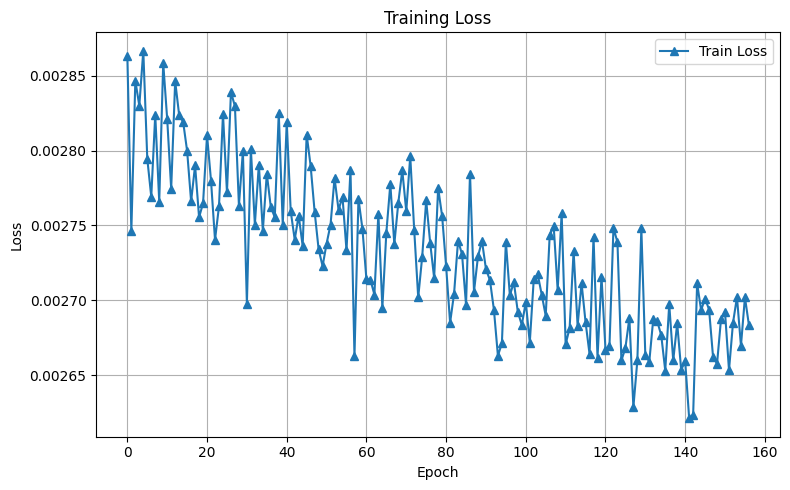

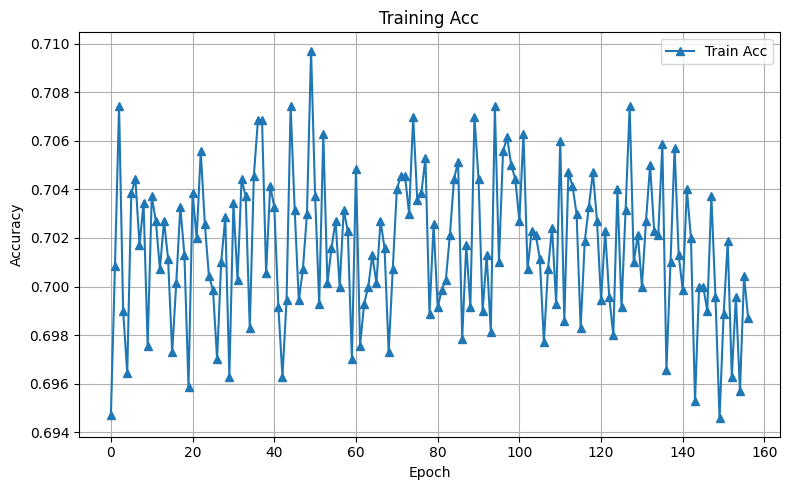

F1 Model State Dict saved
Training Data saved


KeyError: 'epoch'

In [ ]:
import pickle
#? model training and test loop
best_loss_model = pickle.load(open("f1_model.pkl", "rb"))
testingData = train_f1_model(Ivan_NN2, nInputs, best_loss_model, training90_loader, test10_loader,learningRate=learningRate, threshold=threshold)
with open("testingData.pkl", "wb") as f:
    pickle.dump(testingData, f)
    print("Training Data saved")
    
best_loss_model = pickle.load(open("f1_model.pkl", "rb"))
testingData = train_f1_model(Ivan_NN2, nInputs, best_loss_model, training90_loader, test10_loader, learningRate=learningRate, threshold=threshold)

with open("testingData.pkl", "wb") as f:
    pickle.dump(testingData, f)
    print("Training Data saved")
   